In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch

## Linalg

In [6]:
components_to_samples = True  # True for equivariant, False breaks equivariance
model_type = "linear"
# model_type = "ridge"
alpha = 1e-05

In [41]:
# Load
x = np.array(torch.load("/home/pegolo/Downloads/features_block1_L2.pt"), dtype=np.float64)
y = np.array(torch.load("/home/pegolo/Downloads/target_block1_L2.pt"), dtype=np.float64)

print("Before reshaping: x = ", x.shape, "y = ", y.shape)

# Reshape
if components_to_samples:  # equivariant
    x = x.reshape(-1, x.shape[2])
    y = y.reshape(-1, y.shape[2])

else:  # components to properties (non-equivariant)
    x = x.reshape(-1, x.shape[1] * x.shape[2])
    y = y.reshape(-1, y.shape[1] * y.shape[2])

print("After reshaping: x = ", x.shape, "y = ", y.shape)

if model_type == "linear":
    linalg_model = linear_model.LinearRegression(fit_intercept=False)
else:
    assert model_type == "ridge"
    linalg_model = linear_model.Ridge(fit_intercept=False, alpha=alpha)

# Fit
linalg_model.fit(x, y)

# Error
prediction = x @ linalg_model.coef_.T
mse_loss = ((prediction - y) ** 2).mean()
print("MSE loss:", mse_loss)

Before reshaping: x =  (40, 5, 81600) y =  (40, 5, 1)
After reshaping: x =  (200, 81600) y =  (200, 1)
MSE loss: 1.3265963618178713e-31


## GD

In [110]:
use_linalg_weights = False  # Use the weights determined by Linear Algebra
use_random_weights = False  # Use the weights determined by Linear Algebra
use_random_features = False 

In [120]:
import ase

In [123]:
ase.Atoms('H').calc = None

In [111]:
# Set up
torch.set_default_dtype(torch.float64)
x = torch.load("/home/pegolo/Downloads/features_block1_L2.pt").to(dtype=torch.float64)
x = torch.nn.functional.normalize(x, p=1, dim=-1)
if use_random_features:
    x = torch.nn.functional.normalize(torch.randn_like(x), p=1, dim=-1)
y = torch.load("/home/pegolo/Downloads/target_block1_L2.pt").to(dtype=torch.float64)

model = torch.nn.Sequential(
    torch.nn.Linear(in_features=x.shape[-1], out_features=y.shape[-1], bias=False),
)

loss_fn = torch.nn.MSELoss()

if use_linalg_weights:
    # With a low LR we can stay in the minimum
    model[0].weight = torch.nn.Parameter(torch.tensor(linalg_model.coef_).to(dtype=torch.float64))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)
    scheduler = None
elif use_random_weights:
    model[0].weight = torch.nn.Parameter(rweights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)
    scheduler = None
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[5000, 7500, 10000, 15000], gamma=1e-1)

In [112]:
# Train
epochs = 20000
for epoch in range(epochs + 1):
    optimizer.zero_grad()
    prediction = model(x)
    loss = loss_fn(prediction, y)
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()

    if epoch % 500 == 0:
        print("Epoch:", epoch, "Loss:", loss.item(), "LR:", optimizer.param_groups[0]['lr'])

Epoch: 0 Loss: 0.02510843956722407 LR: 0.01
Epoch: 500 Loss: 0.0006991864824409394 LR: 0.01
Epoch: 1000 Loss: 0.0004072535967008755 LR: 0.01
Epoch: 1500 Loss: 0.00022660233723310752 LR: 0.01
Epoch: 2000 Loss: 0.00012150509234688845 LR: 0.01
Epoch: 2500 Loss: 6.390612327871976e-05 LR: 0.01
Epoch: 3000 Loss: 3.4174797908955896e-05 LR: 0.01
Epoch: 3500 Loss: 1.953584658251302e-05 LR: 0.01
Epoch: 4000 Loss: 1.237065417738604e-05 LR: 0.01
Epoch: 4500 Loss: 8.650689928680232e-06 LR: 0.01
Epoch: 5000 Loss: 6.510721998170166e-06 LR: 0.001
Epoch: 5500 Loss: 6.34149376282227e-06 LR: 0.001
Epoch: 6000 Loss: 6.166056689465468e-06 LR: 0.001
Epoch: 6500 Loss: 5.986542213857392e-06 LR: 0.001
Epoch: 7000 Loss: 5.805202018549908e-06 LR: 0.001


KeyboardInterrupt: 

In [63]:
for p in model.parameters():
    wdweights = p.data

(array([3.0000e+00, 1.0000e+00, 4.0000e+00, 5.0000e+00, 8.0000e+00,
        8.0000e+00, 5.0000e+00, 2.0000e+01, 1.9000e+01, 2.0000e+01,
        2.4000e+01, 3.7000e+01, 5.0000e+01, 5.6000e+01, 6.6000e+01,
        6.9000e+01, 1.0800e+02, 1.4400e+02, 2.1200e+02, 2.9900e+02,
        6.9300e+02, 2.3830e+03, 5.7986e+04, 1.6301e+04, 1.5040e+03,
        5.9900e+02, 2.4400e+02, 1.5500e+02, 1.0100e+02, 7.7000e+01,
        6.6000e+01, 6.5000e+01, 6.1000e+01, 3.8000e+01, 4.1000e+01,
        3.5000e+01, 1.7000e+01, 1.2000e+01, 1.4000e+01, 1.1000e+01,
        1.7000e+01, 5.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.58326493, -0.5577406 , -0.53221628, -0.50669195, -0.48116763,
        -0.4556433 , -0.43011898, -0.40459465, -0.37907033, -0.353546  ,
        -0.32802168, -0.30249735, -0.27697302, -0.2514487 , -0.22592437,
        -0.20040005, -0.17487572, -0.1493514 , -0.12382707, -0.09830275,
        -0.07277842, -0.04

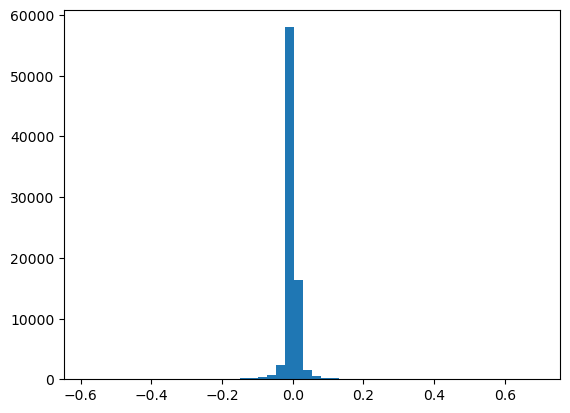

In [40]:
plt.hist(weights.flatten(), bins = 50)

(array([4.000e+00, 5.000e+00, 9.000e+00, 8.000e+00, 1.300e+01, 7.700e+01,
        2.340e+02, 6.070e+02, 3.161e+03, 4.966e+03, 5.114e+03, 4.951e+03,
        5.060e+03, 4.986e+03, 4.972e+03, 4.413e+03, 2.162e+03, 2.020e+02,
        8.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        4.000e+00, 1.000e+00, 5.000e+00, 2.000e+00, 6.000e+00, 6.800e+01,
        1.163e+03, 4.148e+03, 4.762e+03, 4.879e+03, 5.118e+03, 5.103e+03,
        4.991e+03, 4.969e+03, 3.983e+03, 9.620e+02, 3.130e+02, 1.200e+02,
        1.400e+01, 1.200e+01, 5.000e+00, 4.000e+00, 4.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array([-0.0204848 , -0.01961862, -0.01875244, -0.01788626, -0.01702008,
        -0.0161539 , -0.01528771, -0.01442153, -0.01355535, -0.01268917,
        -0.01182299, -0.01095681, -0.01009063, -0.00922445, -0.00835827,
        -0.00749209, -0.00662591, -0.00575973, -0.00489355, -0.00402737,
        -0.00316118, -0.002295  , -0.00142882, -0.00056264,  0.00030354,
         0.

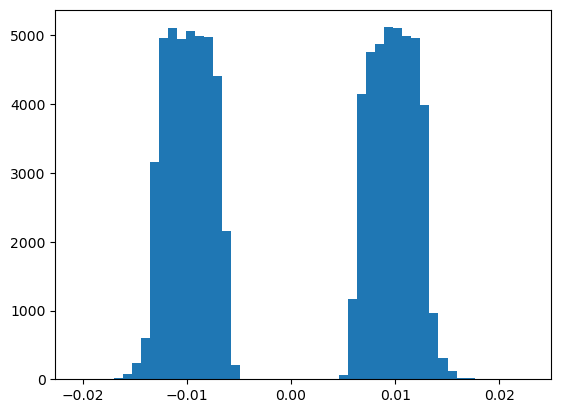

In [21]:
plt.hist(weights.flatten(), bins = 50)

In [27]:
x.norm()

tensor(25.6159)

In [114]:
x = torch.load("/home/pegolo/Downloads/features_block1_L2.pt").to(dtype=torch.float64)
xn = torch.nn.functional.normalize(torch.load("/home/pegolo/Downloads/features_block1_L2.pt").to(dtype=torch.float64), p=1, dim=-1)
# r = torch.nn.functional.normalize(torch.randn_like(x), p=1, dim=-1)
r = torch.nn.functional.layer_norm(torch.randn_like(x), normalized_shape=x.shape)

print(x.norm(), x.mean(), x.var())
print(xn.norm(), xn.mean(), xn.var())
print(r.norm(), r.mean(), r.var())


tensor(25.6159) tensor(-0.0003) tensor(4.0138e-05)
tensor(0.2510) tensor(-1.8788e-06) tensor(3.8582e-09)
tensor(4039.7818) tensor(6.9661e-20) tensor(1.0000)


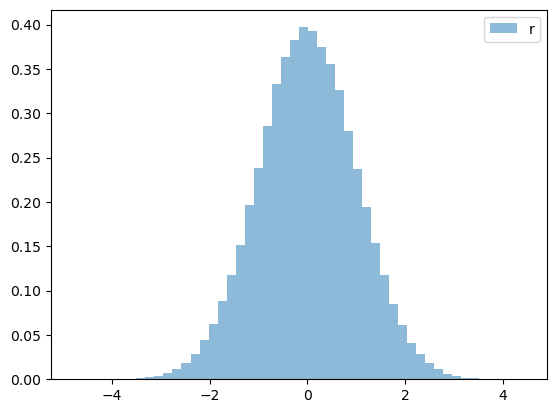

In [119]:
# plt.hist(x.flatten()[::100], bins=50, density = True, alpha = 0.5,label='x');
# plt.hist(xn.flatten()[::100], bins=50, density = True, alpha = 0.5,label='xn');
plt.hist(r.flatten()[::100], bins=50, density = True, alpha = 0.5, label='r');
plt.legend()

(-0.1, 0.1)

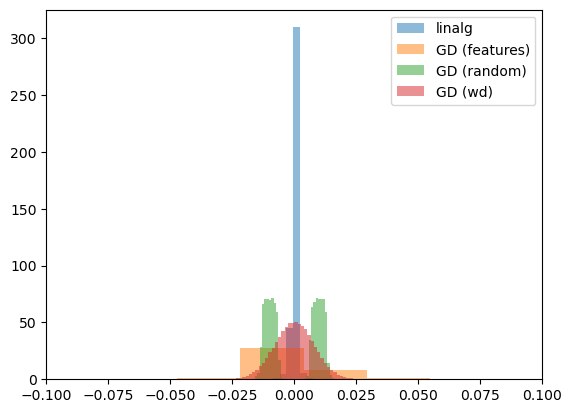

In [64]:
plt.hist(linalg_model.coef_.T.flatten(), bins = 50, label = 'linalg', alpha = 0.5, density = True)
plt.hist(weights.flatten(), bins = 50, label = 'GD (features)', alpha = 0.5, density = True)
plt.hist(rweights.flatten(), bins = 50, label = 'GD (random)', alpha = 0.5, density = True)
plt.hist(wdweights.flatten(), bins = 50, label = 'GD (wd)', alpha = 0.5, density = True)
plt.legend()
plt.xlim(-0.1,0.1)

In [43]:
weights.flatten().shape

torch.Size([81600])

In [125]:
torch.nn.init.xavier_normal_?

Signature: torch.nn.init.xavier_normal_(tensor: torch.Tensor, gain: float = 1.0) -> torch.Tensor
Docstring:
Fills the input `Tensor` with values according to the method
described in `Understanding the difficulty of training deep feedforward
neural networks` - Glorot, X. & Bengio, Y. (2010), using a normal
distribution. The resulting tensor will have values sampled from
:math:`\mathcal{N}(0, \text{std}^2)` where

.. math::
    \text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan\_in} + \text{fan\_out}}}

Also known as Glorot initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    gain: an optional scaling factor

Examples:
    >>> w = torch.empty(3, 5)
    >>> nn.init.xavier_normal_(w)
File:      ~/micromamba/envs/sci/lib/python3.11/site-packages/torch/nn/init.py
Type:      function